In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hydrophone_data_processing import load, preprocessing
import glob
import obspy
from obspy.signal import cross_correlation

from multiprocessing import Pool

inventory = obspy.read_inventory('fdsn-station_2021-06-29T11_00_50.xml', format="STATIONXML")
channels = inventory.networks[0].get_contents()['channels']
networkdf = pd.DataFrame([inventory.get_coordinates(seed_id=id) for id in channels], index=[id for id in channels])
networkdf['station'] = [c.split('.')[1] for c in channels]
networkdf['component'] = [c.split('.')[-1] for c in channels]

In [2]:
event = 1 # 2

In [3]:
stations = !ls /media/sda/data/robdata/PASSCAL/Main_deployment/DAYS/

In [4]:
dataloc = '/media/sda/data/robdata/PASSCAL/Main_deployment/DAYS/'


paths = [glob.glob(dataloc+station+'/*GHZ*.011') for station in stations]
for i, p in enumerate(paths):
    if len(p) == 0:
        paths.pop(i)
paths = np.array(paths).flatten()

In [5]:
stream = load.get_raw_stream(paths)


In [6]:
# if event == 1:
#     stream.trim(starttime=obspy.UTCDateTime('2020-01-11T14:30:00')
#                ,endtime=obspy.UTCDateTime('2020-01-11T15:30:00'))
# elif event == 2:
#     stream.trim(starttime=obspy.UTCDateTime('2020-01-11T19:00:00')
#                ,endtime=obspy.UTCDateTime('2020-01-11T20:00:00'))
# elif event == 3:
#     stream.trim(starttime=obspy.UTCDateTime('2020-01-11T19:45:00')
#            ,endtime=obspy.UTCDateTime('2020-01-11T19:51:00'))
# else:
#     stream.trim(starttime=obspy.UTCDateTime('2020-01-11T12:00:00'))


In [7]:
stream.decimate(factor=2)

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [8]:
stream.detrend('demean')

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [9]:
stream.filter(type='highpass', corners=4, freq=40, zerophase=True)

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [10]:
for tr in stream:
    tr.data = np.abs(tr.data)
stream.decimate(factor=5, no_filter=True)

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.990000Z | 100.0 Hz, 8640000 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.990000Z | 100.0 Hz, 8640000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [11]:
for tr in stream:
    print(tr.stats)
    break

         network: 7F
         station: A12
        location: 
         channel: BHZ
       starttime: 2020-01-11T00:00:00.000000Z
         endtime: 2020-01-11T23:59:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 8640000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1344, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 99962880})
      processing: ["ObsPy 1.2.2: filter(options={'freq': 250.0, 'maxorder': 12}::type='lowpass_cheby_2')", 'ObsPy 1.2.2: decimate(factor=2::no_filter=False::strict_length=False)', "ObsPy 1.2.2: detrend(options={}::type='demean')", "ObsPy 1.2.2: filter(options={'corners': 4, 'freq': 40, 'zerophase': True}::type='highpass')", 'ObsPy 1.2.2: decimate(factor=5::no_filter=True::strict_length=False)']


In [12]:
# stream.filter(type='lowpass', corners=4, zerophase=True, freq=0.5)
# stream.filter(type='lowpass', corners=4, zerophase=True, freq=0.2)
stream.filter(type='lowpass', corners=4, zerophase=True, freq=0.05)

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.990000Z | 100.0 Hz, 8640000 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.990000Z | 100.0 Hz, 8640000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

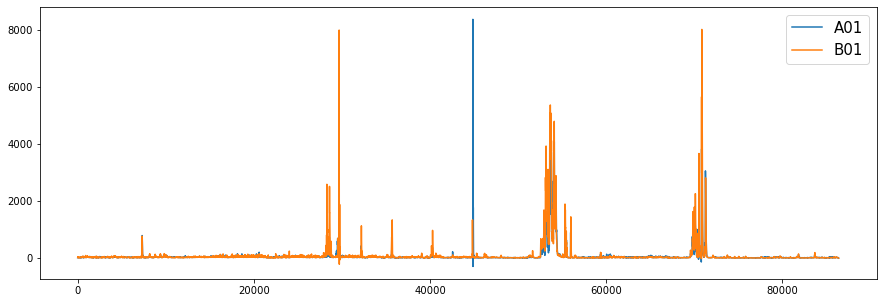

In [13]:
A01 = stream.select(id='7F.A01..BHZ')[0]
B01 = stream.select(id='7F.B01..BHZ')[0]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(A01.times(), A01.data, label='A01')
ax.plot(B01.times(), B01.data, alpha=1, label='B01')

ax.legend(fontsize=15)
# ax.set_xlim(2410, 2450)
# ax.set_xlim(1800, 2300)
# ax.set_xlim(2800, 3200)

In [14]:
networkdf[networkdf.component=='GHZ'].station.unique()

array(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09',
       'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18',
       'A19', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
       'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17',
       'B18', 'B19', 'B20'], dtype=object)

In [15]:
import itertools

ns = []
stations = []
for n, tr in enumerate(stream.traces):
    # print(n, tr.stats.station)
    ns.append(n)
    stations.append(tr.stats.station)

geophones = networkdf[networkdf.component=='GHZ'].station.unique()
gphone_pairs = [h for h in itertools.combinations(stations, 2)]
# gphone_idx = dict(zip(geophones, [1, 19, 36, 37, 17, 18]))
gphone_idx = dict(zip(stations, ns))
# gphone_pairs

In [16]:

stations = [tr.stats.station for tr in stream.traces]
gphone_pairs = [h for h in itertools.combinations(stations, 2)]
shift = 100*40
window_length = 200

def make_row(window):
    rows = []
    for pair in gphone_pairs:
        # print('using pair {pair}'.format(pair=pair),';window:', str(window[0].stats.starttime))
        g1, g2 = pair
        cc = cross_correlation.correlate(a=window[gphone_idx[g1]]
                                         ,b=window[gphone_idx[g2]]
                                        ,shift=shift
                                        ,demean=True
                                        ,normalize=False
                                        )
        
        cc_norm = cross_correlation.correlate(a=window[gphone_idx[g1]]
                                        ,b=window[gphone_idx[g2]]
                                        ,shift=shift
                                        ,demean=True
                                        ,normalize=True
                                        )

        row = {'g1_index':g1 # first hydrophone index used for cross correlation
            , 'g2_index':g2 # second hydrophone index used for cross correlation
            ,'cross_correlation_max':cc.max()
            ,'cross_correlation_index':np.argmax(cc)
            ,'sample_rate':window[0].stats.sampling_rate
            ,'window_starttime':window[0].stats.starttime
            ,'window_endtime':window[0].stats.endtime
            ,'lagtime_seconds':(np.argmax(cc)-shift)/100.
            # ,'cc_estimator':cc
            # ,'cc_estimator_normed':cc_norm
            ,'cc_normed_max':cc_norm.max()
            ,'cc_normed_idx':np.argmax(cc_norm)
            ,'normed_lagtime':(np.argmax(cc_norm)-shift)/100.
            }
        rows.append(row)
        del row, g1, g2, cc, cc_norm
    return rows

def do(window):
    rows = pd.DataFrame(make_row(window))
    fileloc = '/media/sda/data/borehole/cc/{}.csv'.format(str(window[0].stats.starttime))
    rows.to_csv(fileloc, index=False)
    del rows, fileloc
    
    
windows = [w for w in stream.slide(window_length=window_length, step=10)]
# make_row(windows[400])

In [17]:
# gphone_pairs

In [18]:
windows = [w for w in stream.slide(window_length=window_length, step=10)]

In [19]:
windows[0]

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T00:03:20.000000Z | 100.0 Hz, 20001 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T00:03:20.000000Z | 100.0 Hz, 20001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [20]:
# %timeit make_row(windows[0])

In [ ]:
pool = Pool(15)
# rows = pool.map(make_row, windows)
rows = pool.map(do, windows)
pool.close()

In [ ]:
print('it is finished.')

In [27]:
df = load.import_detections(filedir='/media/sda/data/borehole/cc/*.csv')

In [28]:
df

,g1_index,g2_index,cross_correlation_max,cross_correlation_index,sample_rate,window_starttime,window_endtime,lagtime_seconds,cc_normed_max,cc_normed_idx,normed_lagtime
0,A12,A01,1.899994e+07,4188,100.0,2020-01-11T08:20:40.000000Z,2020-01-11T08:24:00.000000Z,1.88,0.776441,4188,1.88
1,A12,A02,1.999511e+07,4218,100.0,2020-01-11T08:20:40.000000Z,2020-01-11T08:24:00.000000Z,2.18,0.770579,4218,2.18
2,A12,A03,1.985674e+07,4210,100.0,2020-01-11T08:20:40.000000Z,2020-01-11T08:24:00.000000Z,2.10,0.788995,4210,2.10
3,A12,A04,2.082508e+07,4242,100.0,2020-01-11T08:20:40.000000Z,2020-01-11T08:24:00.000000Z,2.42,0.769320,4242,2.42
4,A12,A05,1.964658e+07,4265,100.0,2020-01-11T08:20:40.000000Z,2020-01-11T08:24:00.000000Z,2.65,0.774268,4265,2.65
...,...,...,...,...,...,...,...,...,...,...,...
698,B17,B19,5.784573e+05,4000,100.0,2020-01-11T21:59:30.000000Z,2020-01-11T22:02:50.000000Z,0.00,0.537409,4000,0.00
699,B17,B20,4.888780e+05,4110,100.0,2020-01-11T21:59:30.000000Z,2020-01-11T22:02:50.000000Z,1.10,0.582780,4110,1.10
700,B18,B19,1.398585e+06,4364,100.0,2020-01-11T21:59:30.000000Z,2020-01-11T22:02:50.000000Z,3.64,0.462959,4364,3.64
701,B18,B20,8.567674e+05,1112,100.0,2020-01-11T21:59:30.000000Z,2020-01-11T22:02:50.000000Z,-28.88,0.363904,1112,-28.88


In [29]:
print('wtf is going on')

wtf is going on


In [ ]:
cc_df.lagtime_seconds[400]

In [ ]:
plt.plot(cc_df.cc_estimator_normed[400])

In [ ]:
plt.plot(cc_df.cc_estimator[400])

In [ ]:
(np.argmax(cc_df.cc_estimator[400])-shift)/100

In [ ]:
(np.argmax(cc_df.cc_estimator_normed[400])-shift)/100

In [ ]:
cc_df.g1_index.unique()

In [ ]:
cc_df

In [ ]:

# # shift = 100*1
# shift = 100*40
# # window_length = 5
# window_length = 200

# cc_df = pd.DataFrame()

# for window in stream.slide(window_length=window_length, step=10):
#     for pair in gphone_pairs:
#         g1, g2 = pair
#         # g1 = gphone_idx[g1]
#         # g2 = gphone_idx[g2]
#         cc = cross_correlation.correlate(a=window[gphone_idx[g1]]
#                                         ,b=window[gphone_idx[g2]]
#                                         # ,shift=100*1
#                                         ,shift=shift
#                                         ,demean=True
#                                         ,normalize=False
#                                         )
#         cc_norm = cross_correlation.correlate(a=window[gphone_idx[g1]]
#                                         ,b=window[gphone_idx[g2]]
#                                         # ,shift=100*1
#                                         ,shift=shift
#                                         ,demean=True
#                                         ,normalize=True
#                                         )
        
#         window_df = pd.DataFrame(
#             {
#                 'g1_index':(g1,) # first hydrophone index used for cross correlation
#                 , 'g2_index':(g2,) # second hydrophone index used for cross correlation
#                 ,'cross_correlation_max':[cc.max(),]
#                 ,'cross_correlation_index':[np.argmax(cc),]
#                 ,'sample_rate':[window[0].stats.sampling_rate,]
#                 ,'window_starttime':[window[0].stats.starttime,]
#                 ,'window_endtime':[window[0].stats.endtime]
#                 ,'lagtime_seconds':((np.argmax(cc)-shift)/100.,)
#                 ,'cc_estimator':(cc,)
#                 ,'cc_estimator_normed':(cc_norm,)
#                 ,'cc_normed_max':(cc_norm.max(),)
#                 ,'cc_normed_idx':(np.argmax(cc_norm),)
#                 ,'normed_lagtime':((np.argmax(cc_norm)-shift)/100.,)
#             }
#         )
#         cc_df = pd.concat([cc_df, window_df])
# cc_df.reset_index(inplace=True)
# cc_df.head()        

In [ ]:
cc_df[(cc_df.g1_index=='A01') & (cc_df.g2_index=='B01')].lagtime_seconds

In [ ]:
cc_df[(cc_df.g1_index=='A01') & (cc_df.g2_index=='B01') & (cc_df.cc_normed_max>=0.8)].lagtime_seconds

In [ ]:
ax = cc_df[(cc_df.g1_index=='A01') & (cc_df.g2_index=='B01') & (cc_df.cross_correlation_max>=0.1e8)].cross_correlation_max.hist(bins=100)
# ax.set_yscale('log')

In [ ]:
ax = cc_df[(cc_df.g1_index=='A01') & (cc_df.g2_index=='B01') & (cc_df.cross_correlation_max>=0.05e8) & (cc_df.cc_normed_max>=0.8)].lagtime_seconds.hist(bins=100)
# ax.set_yscale('log')

In [ ]:
colors = dict(zip(geophones, ['black', 'red', 'dodgerblue', 'darkorange', 'green', 'cyan']))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

timesteps = 341

x, y = stream.traces[1].times(), stream.traces[1].data
# ax[0].plot(x, y, color='black', label='A01')
ax[0].plot(x, y, color=colors[geophones[0]], label='A01')

x, y = stream[gphone_idx['B01']].times(), stream[gphone_idx['B01']].data
# ax[0].plot(x, y, color='red', label='B01')
ax[0].plot(x, y, color=colors[geophones[1]], label='B01')

for g in geophones[2:]:
    data = stream.traces[gphone_idx[g]]
    # ax[0].plot(data.times(), data.data, label=g)
    ax[0].plot(data.times(), data.data, label=g, color=colors[g])

    
data = cc_df[(cc_df.g1_index=='A01') & (cc_df.g2_index=='B01')].copy()
x, y = np.linspace(0, 3600, timesteps), data['lagtime_seconds'].values
ax[1].plot(x, y, label='A01*B01', color=colors['B01'])

data = cc_df[(cc_df.g1_index=='A01') & (cc_df.g2_index=='B19')].copy()
x, y = np.linspace(0, 3600, timesteps), data['lagtime_seconds'].values
ax[1].plot(x, y, label='A01*B19', color=colors['B19'])

data = cc_df[(cc_df.g1_index=='A01') & (cc_df.g2_index=='B20')].copy()
x, y = np.linspace(0, 3600, timesteps), data['lagtime_seconds'].values
ax[1].plot(x, y, label='A01*B20', color=colors['B20'])

data = cc_df[(cc_df.g1_index=='A01') & (cc_df.g2_index=='A18')].copy()
x, y = np.linspace(0, 3600, timesteps), data['lagtime_seconds'].values
ax[1].plot(x, y, label='A01*A18', color=colors['A18'])

data = cc_df[(cc_df.g1_index=='A01') & (cc_df.g2_index=='A19')].copy()
x, y = np.linspace(0, 3600, timesteps), data['lagtime_seconds'].values
ax[1].plot(x, y, label='A01*A19', color=colors['A19'])



# ax[1].set_xlim(2200, 3200)
# ax[1].set_xlim(2300, 2600)
# ax[1].set_xlim(1200, 3200)
# ax[1].set_xlim(2700, 2850)
# ax[0].set_ylim(0, 1e3)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
# ax[1].set_ylim(-20, 20)
# ax[0].set_xlim(300, 800)
# ax[0].set_ylim(0, 2000)

# ax[1].set_xlim(3000, 3500)
ax[1].set_xlabel('starttime: '+str(stream.traces[0].stats.starttime), fontsize=20)

fig.tight_layout()

In [ ]:
# 3600/720

In [ ]:
for n, tr in enumerate(stream):
    print(n, tr.stats.station)

In [ ]:
# stream.decimate(factor=10, no_filter=True)

In [ ]:
# stream.decimate(factor=10, no_filter=True)

In [ ]:
# stream.decimate(factor=10, no_filter=True)

In [ ]:
# # windows = stream.slide(window_length=10, step=10)
# windows = stream.slide(window_length=1, step=1)

# for w in windows:
#     print([tr.data[0] for tr in w])
#     break

In [ ]:
# use decimate instead of max
# windows = stream.slide(window_length=10, step=10)
# # windows = stream.slide(window_length=1, step=1)
# windows = stream.slide(window_length=0.1, step=0.1)

# maxamp_df = pd.DataFrame()

# for w in windows:
#     stations = [tr.stats.station for tr in w]
#     amps = np.array([tr.data[0] for tr in w])
#     row = dict(zip(stations, amps))
#     wdf = pd.DataFrame(row, index=(pd.to_datetime(str(w[0].stats.starttime)),))
#     maxamp_df = pd.concat([maxamp_df, wdf])

In [ ]:
# windows = stream.slide(window_length=10, step=10)
# # windows = stream.slide(window_length=60, step=60)

# maxamp_df = pd.DataFrame()

# for window in windows:
#     stations = [tr.stats.station for tr in window]
#     ampmax = window.max()
#     row = dict(zip(stations, ampmax))
#     wdf = pd.DataFrame(row, index=[pd.to_datetime(str(window[0].stats.starttime))])
#     maxamp_df = pd.concat([maxamp_df, wdf])

In [ ]:
# plt.hist(maxamp_df.apply(np.log10).values.flatten(), bins=np.linspace(-1, 5, 601//4))
# ''

In [ ]:
# plt.hist(maxamp_df.values.flatten(), bins=np.linspace(0, 1000, 1000))
# plt.yscale('log')

In [ ]:
# eventdir = 'event1_day011/'
# eventdir = 'event2_day011/'

# if event == 1:
#     eventdir = 'event1_day011/'
# elif event == 2:
#     eventdir = 'event2_day011/'
# elif event == 3:
#     eventdir = 'event2_day011_10hz/'
# else:
    # raise ValueError('wtf is an event anyways')

In [ ]:
# lons = networkdf[networkdf.component == 'GHZ'].set_index('station').longitude
# lats = networkdf[networkdf.component == 'GHZ'].set_index('station').latitude

# def makefig(row):
#     row = row[1]
#     fig, ax = plt.subplots(figsize=(10, 10))
#     time = str(row.name)
#     row.name = 'maxamp'
#     stations = row.index
    
#     df = pd.DataFrame([row, lons, lats]).transpose()
#     df['maxamp'] = df.maxamp.apply(np.log10)
#     df.plot.scatter(ax=ax, x='longitude', y='latitude', s=np.exp(df.maxamp)*50
#                     , c='maxamp', cmap='YlGnBu', edgecolor='black'
#                     # , vmin=3.5, vmax=5, alpha=0.75)
#                     , vmin=2, vmax=4, alpha=0.75)
    
#     fig.text(s=time, x=0.15, y=0.15, fontsize=15)
#     fig.savefig('/media/sda/data/borehole/maps/{}-ba1b.png'.format(eventdir+time), dpi=150, bbox_inches='tight')
#     plt.close(fig)


In [ ]:
# rows = [row for row in maxamp_df.iterrows()]

# from multiprocessing import Pool

# pool = Pool(15)
# pool.map(makefig, rows)
# pool.close()

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))

# row = maxamp_df.iloc[31]
# time = str(row.name)
# row.name = 'maxamp'
# stations = row.index

# borehole_locs = networkdf[(networkdf.component=='GDH') & (networkdf.local_depth==35)]

# A00 = borehole_locs[borehole_locs.station=='A00']
# B00 = borehole_locs[borehole_locs.station=='B00']

# ax.plot(A00.longitude, A00.latitude, marker='.', color='black')
# ax.text(s='A00', x=A00.longitude+0.00002, y=A00.latitude, fontsize=12, zorder=0)

# ax.plot(B00.longitude, B00.latitude, marker='.', color='black')
# ax.text(s='B00', x=B00.longitude+0.00002, y=B00.latitude, fontsize=12, zorder=0)

# lons = networkdf[networkdf.component == 'GHZ'].set_index('station').longitude
# lats = networkdf[networkdf.component == 'GHZ'].set_index('station').latitude

# ax.plot()

# df = pd.DataFrame([row, lons, lats]).transpose()
# df['maxamp'] = df.maxamp.apply(np.log10)
# df.plot.scatter(ax=ax, x='longitude', y='latitude', s=np.exp(df.maxamp)*50, c='maxamp', cmap='YlGnBu', edgecolor='None', vmin=3.5, vmax=5, alpha=0.75)

# fig.text(s=time, x=0.15, y=0.15, fontsize=15)

# # fig.tight_layout()
